# Sentiment classification for product review - Yelp
### Natural Language Processing
**Roshan Wahane**

Note: When you see a ``%%time`` statement in the cell, it means that executing that cell will take a long time for it to finish.

## Import libraries
We use the following libraries:

- **(internal):** We use various internal Python libraries for utility purposes
- **pandas:** For dataframe data structure
- **np:** For fast numerical computation and its methods
- **nltk:** For preprocessing the text
- **sklearn:** For fitting and predicting machine learning models on datasets
- **h2o:** For training and predicting deep learning models on datasets
- **matplotlib.pyplot:** For EDA visualisations

In [0]:
!pip install h2o

     |████████████████████████████████| 123.7MB 78kB/s 
  Created wheel for h2o: filename=h2o-3.26.0.9-py2.py3-none-any.whl size=123719079 sha256=f48d09638b7159538b3b3a8c6c422044702104bcc0950070a73b2228dbd6a8c8
  Stored in directory: /root/.cache/pip/wheels/ff/a9/36/487108894572fb92f9262ef16b3db700601992274b9705b214
Successfully built h2o


In [0]:
import os, itertools, string, operator, re, unicodedata, nltk, textwrap
import multiprocessing as mp
import pandas as pd
import numpy as np
from operator import itemgetter
from collections import Counter

'''Text preprocessing'''
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

'''Feature extraction'''
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Phrases
from scipy.sparse import vstack

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_colwidth', 0)

In [0]:
## Download required nltk packages
nltk.download('punkt')
nltk.download('reuters')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Load datasets
We load all three datasets: labeled, unlabeled, and test.

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_path = "drive/Shared drives/FIT5149 A2 Group 21/Datasets"

labeled_data = pd.read_csv(os.path.join(root_path, "labeled_data.csv"))
unlabeled_data = pd.read_csv(os.path.join(root_path, "unlabeled_data.csv"))
test_data = pd.read_csv(os.path.join(root_path, "test_data.csv"))

We examine the first few rows of each dataset.

In [0]:
labeled_data.head()

,text,label
0,"The new rule is - \r\nif you are waiting for a table (which you almost always are) , you cant wait inside. \r\nThey just posted a sign upfront that it causes some concerns for the seated patrons. \r\nHow awful is that? \r\n\r\nI like that they included the apology along with ""especially now in the cold"". \r\n\r\np.s you can try calling in ahead to reserve a table but thats ONLY if the waiting list is short. Otherwise, you have to show up to reserve. Boourns. \r\n\r\n\r\nThis place could do no wrong in my eyes. Rattle away you equally-clever/witty-name-for a hot beverage.\r\n\r\nMust mention - I am obsessed with Mad Gab. \r\n\r\nxoxo\r\nM.",4
1,"Flirted with giving this two stars, but that's a pretty damning rating for what might have just been an off night...\r\n\r\nNew to the East side, and so we don't know many of these hidden gems, but me and the fiance met her friend for drinks here and ended up getting some things to nibble. \r\n\r\nFirst off, service was pretty slow, which was unusual because the restaurant is pretty small and galley style. You would think it would be easy for servers to routinely hit up tables as you pass by. \r\n\r\nThe fiance ordered the Quinoa Salad, and said it was pretty good, but dry. I wasn't too hungry and so I simply ordered the Bruchetta 3-way which came with burnt crostinis. And I ordered a side of fries, which were either hard or chewy.\r\n\r\nThe friend ordered the macaroni & cheese, and added chicken and bacon (her usual order) and liked it. \r\n\r\nCan't remember the last time I thought to myself- ""Huh... they failed at fries..."" So, like I said- two stars. But, the decor was good, it was a good place to have a conversation, and I might be back to try more expensive fare, but-... ah... the fry thing... yeeesh... I dunno, man...",3
2,"I was staying at planet Hollywood across the street and saw good reviews on this place so my husband and I decided to give it a try. We love a good breakfast sandwich. We both ordered the bacon egg and cheese, cold brew, a biscuit and a salted caramel cookie. Everything tasted amazing! The egg is medium so it pops when you take a bite so be prepared for that. The cookie was absolutely delicious and the biscuit was soft and fluffy. We got there are around 10:30am and there was a line already. Luckily the line moves very quick and we were able to find seating. Highly recommend this place.",5
3,"Food is good but prices are super expensive. 8 bucks for the ""Extra Large"" Carne Asada burrito and it's a little bigger then a Taco Bell bean burrito. Don't get me wrong, it's good carne asada but you can get one at Filibertos and it's literally three times the size for 3 bucks.\r\n\r\nLower your prices or make the portions bigger - don't forget that you're using the cheapest cut of beef you can buy, marinating it with some orange juice, garlic and onions and then grilling it. We're not talking Foie gras and heirloom tomatoes. \r\n\r\nAnd seriously, one piece of cucumber and a quarter of a radish?\r\n\r\nI've gone there 4 or five times and each time do I'm left with the same opinion so here it is publicly.",2
4,Worse company to deal with they do horrible work had to bring my truck back on a door replacement the door paint didn't match and trim molding wasn't straight the bolt to keep the door on wasn't even tight. My speaker in the door wasn't hooked back up. I don't recommend anyone to bring the vehicle here. A gentleman by the name of Jesus that works there every time you call for an update because they say they will call you and never do he makes you feel like your bothering him and then he says he will call you back with an update and never do. If you need work on your vehicle I would double think it before you bring it here.,1


There are two columns in the labeled set: "text" (which contains the document), as well as "label" (the corresponding sentiment value for that document).

In [0]:
unlabeled_data.head()

,text
0,"Had a good experience when my wife and I sat at the bar. Great pizza and wings. \r\n\r\nHowever, we tried to go recently with a larger group (8 people) and it was 1.25 hr wait. At 5pm on a Wednesday... Riiiiight. \r\n\r\nI tried to call ahead and they don't accept call aheads. They apparently only have 1 table capable of seating larger parties. Kinda missed the mark on that one Oreganos. Brand spankin new building and all. \r\n\r\nSo we went across the street to Native NewYorker and got seated immediately."
1,"On my first to Montreal with my gf we came here to eat a nice mid day lunch before walking around more and departing from Montreal. Now obviously i am one that has a love/hate relationship with spots that are touristy and well known but in this case it was worth it. I liked the fact that we walked down a nice cobblestone corridor then was greeted by the hostess who promptly showed us to our table. Our seating was right in front where they had two jazz players performing throughout the lunch playing soft melodies for all of the diners entertainment and i always believe with soothing music a meal is always made more enjoyable. \r\n\r\nLooking around this was definite a place i could fall in love with, beautiful flower bed arrangements with different colors that made the restaurant really pop, the large umbrella's which provided a nice cool atmosphere and most importantly shade, plus birds flying around during the meal and nicely arranged plants i loved the ambiance. The food on the other hand could be improved, with such a nicely designed restaurant i would expect a vast selection, also my gf suggested that when your in a new place you should try new food and i 100% agree with that, but in this case i should have just gotten the salmon, because everything else i looked at on the menu, i just was not feeling. Had the veal meatballs style dish and it wasn't that great i'd say it was at best a 6 out of 10 if i had to grade it. But overall the decor/ambiance made up for that. Plus our waitress was extremely helpful/friendly. I also agree with some of the reviews a bit overpriced for what they were serving."
2,One of our favorite places to go when it's cold and rainy out. Re-defines comfort food. And you have to try the Rice Crispy Squares. The best!
3,"The doctor was very nice, got in in a good amount of time and feel like the visit was acceptable. After seeing the doctor I selected my glasses, I was told about this great way they are ordered right from Oakley and how everything was done right at Oakley. I asked them if they could do a rush even said I would pay more. See explained it usually takes 5-7 business days. I was in on July 3 2014 and today July 23 2014 just got them. The lenses ARE NOT Oakley quality the tint is not even to the edge of the lens. I contacted Oakley to find out the aren't even Oakley lenses. Why did I order these and not even get what I ordered. Not happy at all would not recommended buying for brand from this company!!!"
4,"The Nook is an immediate phoenix staple! I came here and met up with the fam, I didn't really have any expectations whatsoever. I feel like that is the best type of experience to have, it really gives any establishment the opportunity to wow their customers. That's exactly what The Nook did for me. I love how it is connected to a hotel with easy access from inside, also the decor was very modern and hipster-ish. This ""new age"" restaurant atmosphere that numbers of restaurant owners have adopted is so amazing. The Nook sets the ambiance to a very relaxed, comfortable feeling which makes it great to come in groups. \r\n\r\nThe mixologist Dustin is very skillful, and constructed the drink menu himself from my understanding. He definitely sets the bar for any other bartender out there. By experimenting with different aromas all the way to different types of seasonings. He truly makes it a day to remember. Check out my pics of the drinks he made, I attached the recipes.\r\n\

The unlabeled set only contains documents in a single column called "text".

In [0]:
test_data.head()

,test_id,text
0,test_1,trying to have a nice quiet dinner. the announcer for the awards giveaways is way too loud in the restaurant
1,test_2,"Been getting food to go from here for over 3yrs. My wife usually tend to get the same items. Why fix something when it works.\r\n\r\nShe always gets the Mongolian Beef lunch special, or dinner. Every once in a while we indulge in the Crab Rangoon. I tend to alternate between the Singapore Noodle, Chicken Fried Rice and the Chow Mai Fun.\r\n\r\nIt's not the best Chinese food I've had, but I never had a complaint regarding the quality and quantity of my food. I've never had to wait longer then 10 mins to pick up my food as well.\r\n\r\nThey recently raised the price on their lunch specials by $0.50, but it is still a killer deal at $5.49.\r\n\r\nGood food, good prices."
2,test_3,"Ugh. I've had to eat here a couple of times because of work events. This of course makes the scantily clad girls super awkward...\r\nIf you're vegan there is not much you can eat. You're looking at an overpriced salad that you've negotiated with the server to make sure you're getting food at all. I called ahead and planned something out with the manager, who was pretty helpful. But it did still mean I was paying a ridiculous amount of $$ for lettuce and a couple of strawberries. And for the most part they are terrible when dealing with people with dietary considerations:\r\n1. I ordered a salad and asked for no meat or cheese. You'd think they would put more of the other ingredients in it to compensate, but no - so I was essentially eating just lettuce with a very very sparse sprinkling of nuts. ALSO they served it WITH THE MEAT! and then clearly just took off the meat and gave it back to me instead of making a new one. EW. The manager apologized and said it wouldn't be charged - very nice. However, this didn't get communicated to the server who DID charge me for it!\r\n2. Their ""vegetarian green beans"" are made with beef broth! When I told the person that that wasn't ""vegetarian"" she argued it was ""just the broth"". I totally don't trust them at ALL to know what's in their food or to care if someone can't eat something."
3,test_4,The people here are so nice! I ordered on eat 24 and they promptly called me to double check that everything was correct it was really sweet! Will definitely be returning! :)
4,test_5,"Heard alot of good things about this place and decided to grab some breakfast burritos today. Have to say we enjoyed our burritos! We had the potato egg and cheese burrito and the chorizo potato and egg burrito.\r\n\r\nFirstly the burritos were rather large, you could easily share if not extremely hungry. But since we both ate our own, we probably won't need lunch! \r\n\r\nThe hot sauce is excellent - spicy . They also have a green sauce and that one is milder but def flavorful.\r\n\r\nDefinitely will be back to try their other dishes."


The test set contains two columns: "test_id" (to identify the document), and "text" (which contains the document itself).

## Text preprocessing
The data preparation stage consists of the following steps:

1. **Tokenization:** We tokenize the text using TwitterTokenizer
2. **Expand contractions:** We expand contractions (such as "don't" -> "do not") for each token
3. **Stemming:**  We reduce the vocabulary by removing inflections in words and putting them in stemmed format.
4. **Remove misleading characters**: These include removing stopwords.

Below is the implementation for the data preparation stage:

In [0]:
def preprocess_text(text):
    ## Tokenise text
    tokenized = casual_tokenizer(text)

    ## Expand contractions for each token
    decontract = (expandContractions(item, c_re=c_re) for item in tokenized)

    ## Stem tokens
    stemmer = nltk.stem.porter.PorterStemmer()
    stemmed = (stemmer.stem(token) for token in decontract)

    ## Remove misleading characters
    tidied_text = remove_misleading_characters(stemmed)

    ## Return result
    preprocessed_text = list(tidied_text)
    return preprocessed_text

We now go each step of the data preparation stage, to see how they are implemented.

### Decontracting words
We map each contraction to its expansion.

In [0]:
## Define contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

## Combine all keys into a list of ors
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

In [0]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

### Tokenizer
We use the Twitter tokenizer to tokenize the text, in case we have emojis in our dataset.

In [0]:
def casual_tokenizer(text):
    """Splits words on white spaces (leaves contractions intact) and splits out
    trailing punctuation"""
    tokenizer = TweetTokenizer() # TreebankWordTokenizer() is worse
    tokens = tokenizer.tokenize(text)
    return tokens

### Remove misleading characters
This final preprocessing step aims to remove the noise from the signal.

In [0]:
def remove_misleading_characters(text):
    ## Remove numbers
    no_num = (re.sub('[0-9]+', '', each) for each in text)
    
    ## Remove punctuation
    no_punc = (w for w in no_num if w not in string.punctuation)

    ## Return result
    tidied_text = list(no_punc)
    return tidied_text

### Preprocessing the text
Putting all of this together, we preprocess the text, and save the results in a new column.

In [0]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    labeled_data['clean_text'] = pool.map(preprocess_text, labeled_data['text'])

CPU times: user 1.5 s, sys: 506 ms, total: 2 s
Wall time: 2min 8s


In [0]:
labeled_data.head()

,text,label,clean_text
0,"The new rule is - \r\nif you are waiting for a table (which you almost always are) , you cant wait inside. \r\nThey just posted a sign upfront that it causes some concerns for the seated patrons. \r\nHow awful is that? \r\n\r\nI like that they included the apology along with ""especially now in the cold"". \r\n\r\np.s you can try calling in ahead to reserve a table but thats ONLY if the waiting list is short. Otherwise, you have to show up to reserve. Boourns. \r\n\r\n\r\nThis place could do no wrong in my eyes. Rattle away you equally-clever/witty-name-for a hot beverage.\r\n\r\nMust mention - I am obsessed with Mad Gab. \r\n\r\nxoxo\r\nM.",4,"[the, new, rule, is, if, you, are, wait, for, a, tabl, which, you, almost, alway, are, you, cant, wait, insid, they, just, post, a, sign, upfront, that, it, caus, some, concern, for, the, seat, patron, how, aw, is, that, I, like, that, they, includ, the, apolog, along, with, especi, now, in, the, cold, p, s, you, can, tri, call, in, ahead, to, reserv, a, tabl, but, that, onli, if, the, wait, list, is, short, otherwis, you, have, to, show, up, to, reserv, boourn, thi, place, could, do, no, wrong, in, my, eye, rattl, away, you, equally-clev, witty-name-for, a, hot, beverag, ...]"
1,"Flirted with giving this two stars, but that's a pretty damning rating for what might have just been an off night...\r\n\r\nNew to the East side, and so we don't know many of these hidden gems, but me and the fiance met her friend for drinks here and ended up getting some things to nibble. \r\n\r\nFirst off, service was pretty slow, which was unusual because the restaurant is pretty small and galley style. You would think it would be easy for servers to routinely hit up tables as you pass by. \r\n\r\nThe fiance ordered the Quinoa Salad, and said it was pretty good, but dry. I wasn't too hungry and so I simply ordered the Bruchetta 3-way which came with burnt crostinis. And I ordered a side of fries, which were either hard or chewy.\r\n\r\nThe friend ordered the macaroni & cheese, and added chicken and bacon (her usual order) and liked it. \r\n\r\nCan't remember the last time I thought to myself- ""Huh... they failed at fries..."" So, like I said- two stars. But, the decor was good, it was a good place to have a conversation, and I might be back to try more expensive fare, but-... ah... the fry thing... yeeesh... I dunno, man...",3,"[flirt, with, give, thi, two, star, but, that i, a, pretti, damn, rate, for, what, might, have, just, been, an, off, night, ..., new, to, the, east, side, and, so, we, do not, know, mani, of, these, hidden, gem, but, me, and, the, fianc, met, her, friend, for, drink, here, and, end, up, get, some, thing, to, nibbl, first, off, servic, wa, pretti, slow, which, wa, unusu, becaus, the, restaur, is, pretti, small, and, galley, style, you, would, think, it, would, be, easi, for, server, to, routin, hit, up, tabl, as, you, pass, by, the, fianc, order, the, quinoa, salad, and, said, ...]"
2,"I was staying at planet Hollywood across the street and saw good reviews on this place so my husband and I decided to give it a try. We love a good breakfast sandwich. We both ordered the bacon egg and cheese, cold brew, a biscuit and a salted caramel cookie. Everything tasted amazing! The egg is medium so it pops when you take a bite so be prepared for that. The cookie was absolutely delicious and the biscuit was soft and fluffy. We got there are around 10:30am and there was a line already. Luckily the line moves very quick and we were able to find seating. Highly recommend this place.",5,"[I, wa, stay, at, planet, hollywood, across, the, street, and, saw, good, review, on, thi, place, so, my, husband, and, I, decid, to, give, it, a, tri, We, love, a, good, breakfast, sandwich, We, both, order, the, bacon, egg, and, chees, cold, brew, a, biscuit, and, a, salt, caramel, cooki, everyth, tast, amaz, the, egg, is, medium, so, it, pop, when, you, take, a, bite, so, be, prepar, for

## Feature extraction
We use tf-idf to vectorize the preprocessed text. We extract both unigrams and bigrams from each document. We also do more preprocessing, by removing words that only occur once, and words appearing in more than 95% of documents.

In [0]:
def extract_features(texts):
    # Only considering unigrams and bigrams
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                    min_df = 2, 
                                    max_df = .95)

    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    return transformed_texts, tfidf_vectorizer

We extract features from the labelled dataset, and we save the vectorizer, so that we can transform the unlabelled and test datasets using the same bag-of-words as the labelled datasets.

In [0]:
%%time
''' -------- !!! EXPENSIVE !!! -------- '''
# Creating the features (tf-idf weights) for the processed text
text = labeled_data['clean_text'].astype('str')
X, tfidf_vectorizer = extract_features(text)
y = labeled_data['label'].values # target

CPU times: user 22.5 s, sys: 263 ms, total: 22.8 s
Wall time: 22.8 s


### Dimensionality reduction
We have more than 300k tokens. Since any document is unlikely to have too many unique tokens, and it would take too much computational resources to process all tokens, we have decided to reduce the number of dimensions to 500.

In [0]:
def reduce_dimensions(X):
    lsa = TruncatedSVD(n_components=500, n_iter=10, random_state=3)
    return lsa.fit_transform(X)

In [0]:
%%time
X_new = reduce_dimensions(X)

CPU times: user 8min 37s, sys: 20.7 s, total: 8min 58s
Wall time: 7min 29s


In [0]:
X_new

array([[ 0.1639799 ,  0.08059258, -0.06497316, ...,  0.0007979 ,
        -0.01224931,  0.01333909],
       [ 0.26331417, -0.06631381,  0.00257641, ..., -0.0162723 ,
        -0.01417977,  0.00602489],
       [ 0.20646348, -0.07610774,  0.02025546, ..., -0.02327162,
        -0.0083097 ,  0.00220273],
       ...,
       [ 0.19029497,  0.08605543,  0.00871069, ..., -0.00497382,
         0.00097687, -0.0191207 ],
       [ 0.16773658,  0.10370696, -0.03958488, ...,  0.025419  ,
        -0.01261465,  0.01136425],
       [ 0.17534244,  0.02163348,  0.03427538, ...,  0.00475678,
        -0.01782363,  0.02703127]])

In [0]:
X_dataframe = pd.DataFrame.from_records(X_new)

In [0]:
y_dataframe = pd.DataFrame(y)

## Exploratory data analysis
We perform exploratory data analysis on our labelled dataset, so that we can gain more insights, and potentially form better decisions in model development stage.

### Summary of token, document, and vocabulary statistics
We first determine the minimum, maximum, and average number of tokens each document has. We can do this by counting how many elements are nonzero along each row in the document-term matrix.


In [0]:
pd.Series(labeled_data["clean_text"].apply(len)).describe()

count   50,000.0000
mean    121.9508   
std     111.6847   
min     1.0000     
25%     48.0000    
50%     88.0000    
75%     157.0000   
max     1,015.0000 
Name: clean_text, dtype: float64

As specified in the assignment document, there are 50,000 documents total in the labelled dataset. We have 121.9508 tokens on average. The document with the least number of tokens only has 1 token in it. The document with the most number of tokens has 1,015 tokens.

Now let us look at the shapes of the extracted features, as well as their corresponding labels.

In [0]:
print(X.shape)
print(y.shape)

(50000, 341801)
(50000,)


Like what we found earlier, there are 50,000 labelled documents. The number of columns in the extracted feature matrix tells us that there are 341,801 unigrams/bigrams in the vocabulary of the labelled dataset.

### Unique character set
We find out which characters are being used in the labeled set.

In [0]:
set_of_words = labeled_data.text.apply(lambda x: set(x)).values
uniq_chars = "".join(set(itertools.chain.from_iterable(set_of_words)))
uniq_chars = "".join(sorted(uniq_chars))
print(uniq_chars)


 !"#$%&'()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÂÃÄÅâãäåæçèéï


We see that all alphabetical letters are being used (both uppercase and lowercase). We also see some special characters, such as ¶, which is quite peculiar.

In [0]:
labeled_data[labeled_data["text"].str.contains('¶')]

,text,label,clean_text
4323,ï¼ãæåãã¾ããï¼å¤§å¥½ãã§ãã\r\nï¼ãç¾å³ããï¼æ²¢å±±ã®äººã«ç´¹ä»ãããï¼\r\nï¼ãã¢ãã¬ã¼ã¸ï¼\r\nï¼ãç§ã®å¥½ã¿ã§ã¯ããã¾ããã§ãããã§ãã¾ããã¤ããã£ã¬ã³ã¸ãã¦ãããããªããã\r\nï¼ãããäºåº¦ã¨ä¼ºããã¨ã¯ããã¾ããã\r\n\r\nãã¼ã«ã®ç¨®é¡ãè±å¯ï¼\r\nä½ãããããªã®ãããã¼ã«ã°ã©ã¹ããã¤ãç¶ºéºã«æ´æµããã¦ãããã¨ï¼\r\n\r\nãã­ã³ãã§ã¯ãããã§ãã¼ã«ãé£²ãã®ã1çªå¥½ãããã,3,"[ï¼, , ã, , , æ, , , å, , , ã, , , ã, , ¾ã, , , ã, , , ï¼, , å, ¤, §, å, ¥, ½ã, , , ã, , §, ã, , , ã, , , ï¼, , ã, , , ç¾, , å, , ³ã, , , ã, , , ï¼, , æ², ¢, å, ±, ±, ã, , ®, äººã, , «, ç, ´, ¹ä, », , ã, , , ã, , , ã, , , ï¼, , ï¼, , ã, , , ã, , ¢, ã, , , ã, , ¬, ã, ...]"
4949,"Wir haben im Mai die ""Historic Boulder City""-Tour gemacht.\r\nGebucht haben wir von Deutschland aus per Mail und mit Gutscheinen von MyVegas. Unsere Tour war somit komplett kostenlos. (Inzwischen gibt es Ã¼ber MyVegas nur noch 2-fÃ¼r-1 oder 50$-Rabatt-Gutscheine.) Der Normalpreis fÃ¼r diese Tour liegt bei 189$ pro Person und wir haben das angemessen empfunden.\r\nWir wurden morgens am Hotel mit einem Mini-Van abgeholt und fuhren dann zu einem weiteren Hotel um die restlichen Teilnehmer einzuladen.\r\nWÃ¤hrend der Fahrt hat Chuck (unser Tourguide) uns gut unterhalten. \r\nVor Ort angekommen wartete schon Chris (vom Support) mit den Segways auf uns. FÃ¼r alle standen Helme, KopfhÃ¶rer und viel kaltes Wasser bereit. Nachdem jeder auf dem groÃem Parkplatz in die Bedienung des Segways eingewiesen wurde und sich sicher fÃ¼hlte, ging die Tour los.\r\nZuerst fuhren wir durch die Stadt zum Museum. Dort hatten wir ca. eine 1/2 Stunde Aufenthalt. Der Eintrittspreis ist bereits inklusive. Hier hat man auch die MÃ¶glichkeit zur Toilette zu gehen.\r\nDas Museum beschÃ¤ftigt sich mit dem Bau des Hoover Dams (fÃ¼r die Arbeiter wurde Boulder City damals gebaut) und ist recht interessant.\r\nDanach ging die Tour weiter und es gab richtig lange Strecken zu fahren. Die Strecken sind sehr gut gewÃ¤hlt, man gerÃ¤t nirgendwo in brenzlige Situationen und fÃ¼r ""Neugierige"" gibt es viele MÃ¶glichkeiten zu testen, was ein Segway so alles kann.\r\nAn einer Stelle hat uns Chuck ""Big Horn Sheeps"" versprochen, aber die hatten an dem Tag wohl schon etwas besseres vor. ;-)\r\nAuf einem Berg - im Hintergrund sehr malerisch der Lake Mead - wurde ein Erinnerungsfoto gemacht, dass uns hinterher per Mail zugesendet wurde (kostenlos).\r\nZum AbschluÃ fuhren wir dann noch zum Lunch (im Preis inklusive). Man wird bereits bei der Buchung gefragt, was man gerne essen mÃ¶chte. Bei uns standen 5 oder 6 Gerichte zur Auswahl. Die QualitÃ¤t war ... naja ... Wir wÃ¼rden dort jedenfalls keinesfalls nochmal hingehen. Insgesamt hat das Essen aber wohl doch bei einigen den Geschmack getroffen. Es sind jedenfalls sehr groÃe und fettige Portionen. Eiskalte Softdrinks waren dort ebenfalls inklusive.\r\nAnschlieÃend ging zurÃ¼ck zum Van.\r\nChuck ist auf dem RÃ¼ckweg noch mit uns zum Hoover Dam gefahren, dort gab es allerdings nur einen kurzen Stop. AnschlieÃend wurden alle wieder zu Ihren Hotel (oder zum Wunschziel) gefahren.\r\n\r\nWir werden auf jeden Fall wieder eine Tour buchen, denn uns hat es supergut gefallen. Die Segways waren top in Schuss, Chuck und Chris hatten allzeit ein Auge darauf, dass alle gut klar kommen und sind geduldig und freundlich mit jedem, der etwas zÃ¶gerlich ist. Chuck wusste viel Ã¼ber Boulder City zu erzÃ¤hlen.\r\nJedes Segway hat vorne einen Rucksack, in dem man seine persÃ¶nlichen Sachen und GetrÃ¤nke verstauen kann.\r\nUnser Tipp: Bei Sonne auf jeden Fall Sonnenschutz verwenden - und dabei die HÃ¤nde nicht vergessen!",5,"[wir, haben, im, mai, die, histor, boulder, citi, tour, gemacht, gebucht, haben, wir, von, deutschland, au, per, mail, und, mit, gutscheinen, von, m

It appears that some examples have special characters, which may be due to character encoding issues for languages other than English. Speaking of which, we have found examples where the language is not English (for example, the text beginning with "Wir haben im Mai" is written in German). Using an English lemmatizer is not worth the effort, since it would not correctly identify the part-of-speech of each non-English word, and it would be more computationally expensive than using an English stemmer.

We will leave these examples intact, since the unlabeled dataset and test set may also contain special characters.

In [0]:
print(unlabeled_data[unlabeled_data["text"].str.contains('¶')].shape)
print(test_data[unlabeled_data["text"].str.contains('¶')].shape)

(243, 1)
(22, 2)


### Most frequent words for all the articles
We examine top 50 words in the labeled corpus.

In [0]:
def most_frequent_words(clean_text_list, top_n):
    """Determines the most top_n words, and produces the
    results as a dataframe.
    """
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    df = pd.DataFrame([word, num]).T
    df.columns = ["word", "frequency"]
    return df

In [0]:
cl_text_list = labeled_data['clean_text'].tolist()
most_frequent_words(cl_text_list, 50)

,word,frequency
0,the,306739
1,and,199805
2,I,163973
3,to,153650
4,a,149140
5,wa,114770
6,of,86354
7,for,73933
8,it,70868
9,is,66918


Since we have not removed most frequent words from the corpus, we can see function words appearing at the top of the list (with "the" being the most common word).

We also see sentiment words "good" and "like", which are highly frequent words that **should not** be removed from the corpus.

### Average word count by category
We look at the average word count for the labeled dataset, grouped by label assigned to each text example.


In [0]:
def word_count(text):
    return len(str(text).split(' '))

In [0]:
labeled_data['word_count'] = labeled_data['text'].apply(word_count)
avg_wc = labeled_data.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,1,143.1546
1,2,142.3546
2,3,130.6147
3,4,114.4627
4,5,87.5482


From above we can see that negative reviews have longer word count than positive reviews as people tend to write more about their negative experience compared to positive experience.

### Distribution of word count by class


In [0]:
# splitting dataframe as per category
label_1 = labeled_data[labeled_data['label'] == 1]
label_2 = labeled_data[labeled_data['label'] == 2]
label_3 = labeled_data[labeled_data['label'] == 3]
label_4 = labeled_data[labeled_data['label'] == 4]
label_5 = labeled_data[labeled_data['label'] == 5]

In [0]:
label_1.head()

,text,label,clean_text,word_count
4,Worse company to deal with they do horrible work had to bring my truck back on a door replacement the door paint didn't match and trim molding wasn't straight the bolt to keep the door on wasn't even tight. My speaker in the door wasn't hooked back up. I don't recommend anyone to bring the vehicle here. A gentleman by the name of Jesus that works there every time you call for an update because they say they will call you and never do he makes you feel like your bothering him and then he says he will call you back with an update and never do. If you need work on your vehicle I would double think it before you bring it here.,1,"[wors, compani, to, deal, with, they, do, horribl, work, had, to, bring, my, truck, back, on, a, door, replac, the, door, paint, did not, match, and, trim, mold, was not, straight, the, bolt, to, keep, the, door, on, was not, even, tight, My, speaker, in, the, door, was not, hook, back, up, I, do not, recommend, anyon, to, bring, the, vehicl, here, A, gentleman, by, the, name, of, jesu, that, work, there, everi, time, you, call, for, an, updat, becaus, they, say, they, will, call, you, and, never, do, he, make, you, feel, like, your, bother, him, and, then, he, say, he, will, call, you, ...]",124
7,"Due to misunderstanding between my insurance company and CRS Temporary Housing, they send me a collection letter with falsified attachments. It was a contract not even related to my claim. Very unprofessional. Very sneaky. Very illegal.",1,"[due, to, misunderstand, between, my, insur, compani, and, cr, temporari, hous, they, send, me, a, collect, letter, with, falsifi, attach, It, wa, a, contract, not, even, relat, to, my, claim, veri, unprofession, veri, sneaki, veri, illeg]",36
13,"I was so hoping things would improve for me with this overpriced foodstore. Unfortunately, certain staff members apparantly thinks their poop don't stink. Like the hippie idiotic woman who served me pizza tonite. I had asked her for some cheese pizza from the opposite end facing her. Sighing, she turned it around and cut a slice and then cut it in two. She then asked if I wanted the ""whole strip"". Well, there were now two pieces, weren't there? So it confused me. So I bend down to see what she was doing, and just said ""um,"" and that was all it took for her to stay loudy and rudely ""I CAN'T HEAR YOU!"". Really sweetheart? I think I meant to say F O. Hear that? Before boxing up my slices, she made sure to hastily scoop then up and bang them into the sides of the display, touching everything. Classy, Miss Hippie. Did they teach you how to serve food at the dirt farm that was obviously your last place of employment?\r\n\r\nResidents of Las Vegas: if you too would like to experience overpriced food in a terribly designed strip mall with a dangerous and near impossible exit onto Rampart, coupled with service you expect to find in a junk store....all wrapped up in one...make sure you visit this location of Crap Foods. Maybe next time I shouldn't wear my ""culture warrior"" shirt, lol. Hippies.",1,"[I, wa, so, hope, thing, would, improv, for, me, with, thi, overpr, foodstor, unfortun, certain, staff, member, apparantli, think, their, poop, do not, stink, like, the, hippi, idiot, woman, who, serv, me, pizza, tonit, I, had, ask, her, for, some, chees, pizza, from, the, opposit, end, face, her, sigh, she, turn, it, around, and, cut, a, slice, and, then, cut, it, in, two, she, then, ask, if, I, want, the, whole, strip, well, there, were, now, two, piec, were not, there, So, it, confus, me, So, I, bend, down, to, see, what, she, wa, do, and, just, said, um, and, that, wa, ...]",240
16,That moment when you're 38 days behind and they repo your SUV after 10 pm Sunday and before 5 am Monday no warning. You've just gotta laugh at a company. I'm good I'll take the bus before I have to deal with this company again!,1,"[that, moment, when, you ar, day, behind, and, they, repo, your, suv, after, pm, sunday, and,

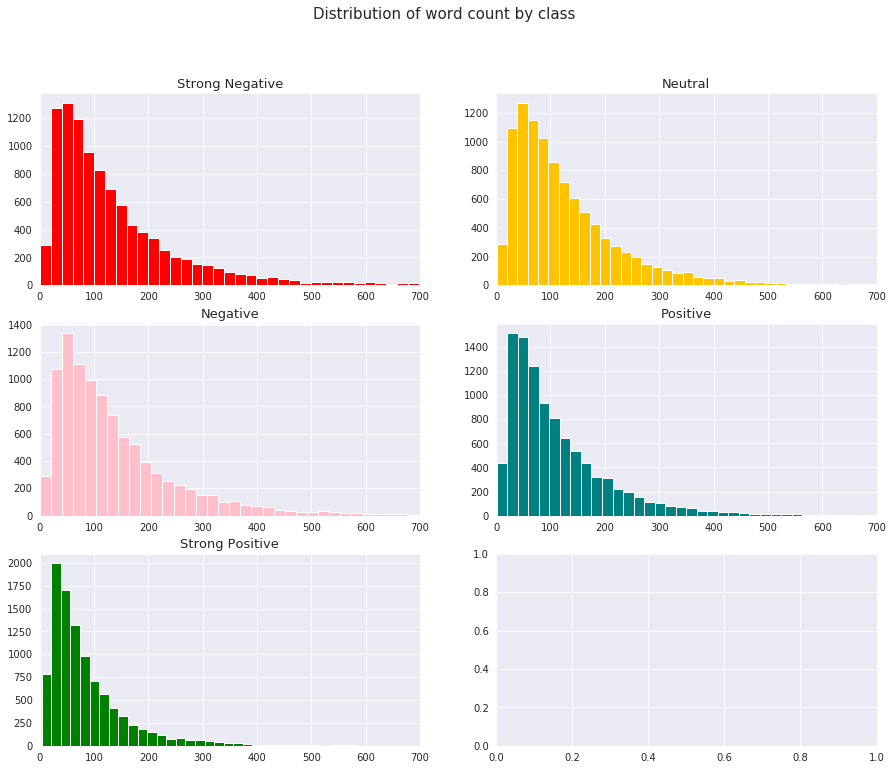

In [0]:
# Plots the distribution of word count by class
fig, ax = plt.subplots(3, 2, figsize = (15,12))
fig.suptitle('Distribution of word count by class', fontsize=15)

bins = 50

ax[0, 0].hist(label_1['word_count'], bins = bins, color = 'red')
ax[0, 0].set_title('Strong Negative', fontsize = 13)
ax[0, 0].set_xlim(0, 700)

ax[0, 1].hist(label_3['word_count'], bins = bins, color = '#FFC300')
ax[0, 1].set_title('Neutral', fontsize = 13)
ax[0, 1].set_xlim(0, 700)

ax[1, 0].hist(label_2['word_count'], bins = bins, color = 'pink')
ax[1, 0].set_title('Negative', fontsize = 13)
ax[1, 0].set_xlim(0, 700)

ax[1, 1].hist(label_4['word_count'], bins = bins, color = 'teal')
ax[1, 1].set_title('Positive', fontsize = 13)
ax[1, 1].set_xlim(0, 700)

ax[2, 0].hist(label_5['word_count'], bins = bins, color = 'green')
ax[2, 0].set_title('Strong Positive', fontsize = 13)
ax[2, 0].set_xlim(0, 700)

plt.show()

Like what we saw in average word count, we can see bars with word counts beyond 500 words in the "Strongly Negative" category, but there are no bars beyond 400 words in the "Strongly Positive" category. The higher the rating, the distribution becomes more narrow, with more text examples having a low word count.

### Top 50 unigrams/bigrams per class
We find the top 50 unigrams/bigrams for each category in the labeled dataset.

In [0]:
def word_freq_bigrams(clean_text_list, top_n):
    """
    Word frequency with bigrams
    """
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    
    return pd.DataFrame([word, num]).T


def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [0]:
%%time
top_n = 50

text_label_1 = label_1['clean_text'].tolist()
text_label_2 = label_2['clean_text'].tolist()
text_label_3 = label_3['clean_text'].tolist()
text_label_4 = label_4['clean_text'].tolist()
text_label_5 = label_5['clean_text'].tolist()

wf_label_1 = word_freq_bigrams(text_label_1, top_n=top_n)
wf_label_2 = word_freq_bigrams(text_label_2, top_n=top_n)
wf_label_3 = word_freq_bigrams(text_label_3, top_n=top_n)
wf_label_4 = word_freq_bigrams(text_label_4, top_n=top_n)
wf_label_5 = word_freq_bigrams(text_label_5, top_n=top_n)

CPU times: user 34.7 s, sys: 274 ms, total: 34.9 s
Wall time: 35 s


In [0]:
wf_data = pd.concat([wf_label_1, wf_label_2, wf_label_3, wf_label_4, wf_label_5], axis=1)
cols = ['label_1_strngneg', 'count', 'label_2_neg', 'count', 'lebel_3_neut', 'count', 
        'label_4_pos', 'count', 'label_5_strngpos', 'count']
wf_data.columns = cols
wf_data

,label_1_strngneg,count,label_2_neg,count,lebel_3_neut,count,label_4_pos,count,label_5_strngpos,count
0,and,37078,and,34070,and,30474,and,30205,and,24915
1,the,23296,the,26679,the,25113,the,21903,the,13482
2,to,15296,to,10959,a,10430,a,8900,a,5986
3,that,10340,a,10572,to,8024,to,6711,to,5748
4,a,9710,that,9615,wa,7961,wa,5966,wa,4353
5,wa,8588,wa,8830,that,7832,for,5359,for,3725
6,for,7536,it,7401,it,6381,of,5113,in,3635
7,I,7316,for,7291,for,6316,it,4914,is,3316
8,it,6692,of,6138,but,6113,that,4837,with,3187
9,in,6360,but,6132,of,5925,is,4621,that,3183


We see the words "great", "the best", "like" and "not" in the "Strongly Positive" category. The rank for the word "not" is 35 for "Strongly Positive" category, and rank 13 for "Strongly Negative" category. The words "great" and "the best" are not present in the "Strongly Negative" category.

The frequency of the word "but" across the categories forms a negative quadratic. It is used the most in the "Neutral" category (at rank 8), and is used the least in "Strongly Negative" and "Strongly Positive" categories (at ranks 12 and 14, respectively).

## Model development
We develop the following models:

- [Stochastic gradient descent](https://scikit-learn.org/stable/modules/sgd.html)
- [Multinomial naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)
- Deep learning

### Training-validation approach 
We split the data into train and test proportions on the labeled dataset.

In [0]:
# Train test split with stratified sampling for evaluation
X_train, X_validation, y_train, y_validation = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

### Stochastic gradient descent

In [0]:
sgd_model = SGDClassifier(random_state=3, loss='log')
sgd_model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=3, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

We can see the parameter we have set for the model, in addition to default parameters.

### Multinomial naive Bayes

In [0]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Like with the stochastic gradient descent model, we see default parameters for the multinomial naive Bayes model.

### Deep learning

In [0]:
## Initialising h20 cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpa7rpt8qe
  JVM stdout: /tmp/tmpa7rpt8qe/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpa7rpt8qe/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_unknownUser_taslmj
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Combining labeled, unlabeled and test data to make sure tokens and dimension are consistent. 

In [0]:
## Merging three datasets into one 
merged_data = labeled_data
merged_data = merged_data.append(unlabeled_data[0:1500])
merged_data = merged_data.append(test_data)

In [0]:
%%time
## Performing the text preprocessing 
with mp.Pool(mp.cpu_count()) as pool:
    merged_data['clean_text'] = pool.map(preprocess_text, merged_data['text'])

CPU times: user 4.05 s, sys: 1.08 s, total: 5.14 s
Wall time: 4min 31s


In [0]:
## Tokenising the data and extracting the features 
text = merged_data['clean_text'].astype('str')
X, tfidf_vectorizer_deeplearning = extract_features(text)
y = labeled_data['label'].values # target

In [0]:
%%time
## Reducing the dimension of the data 
X_new = reduce_dimensions(X)

CPU times: user 16min 19s, sys: 53.9 s, total: 17min 13s
Wall time: 14min 41s


In [0]:
## Transforming the data to dataframe which is needed in h2o packages 
X_dataframe = pd.DataFrame.from_records(X_new)

In [0]:
## The first 50000 rows of data are labeled data and it is extracted for model training 
X_dataframe = X_dataframe.iloc[0:50000,]

In [0]:
## y dataframe has all the labels and it is converted to dataframe for h2o to process 
y_dataframe = pd.DataFrame(y)

In [0]:
## Spliting the data into training and testing set
X_train_deeplearning, X_validation_deeplearning, y_train_deeplearning, y_validation_deeplearning = train_test_split(X_dataframe, 
                                                    y_dataframe, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [0]:
## Converting the training and testing data to dataframe which will be converted to h20 dataframe 
X_train_deeplearning = pd.DataFrame(X_train_deeplearning)
y_train_deeplearning = pd.DataFrame(y_train_deeplearning)
X_validation_deeplearning = pd.DataFrame(X_validation_deeplearning)
y_validation_deeplearning = pd.DataFrame(y_validation_deeplearning)

In [0]:
## Adding label data to the training dataset 
X_train_deeplearning["Class"] = y_train_deeplearning

In [0]:
## Converting the column to string which is required for the h2o dataframe conversion 
X_train_deeplearning.columns = X_train_deeplearning.columns.astype('str')
X_validation_deeplearning.columns = X_validation_deeplearning.columns.astype('str')
y_validation_deeplearning.columns = y_validation_deeplearning.columns.astype('str')

In [0]:
## Converting the dataframe to h2o dataframe 
X_train_deeplearning = h2o.H2OFrame(X_train_deeplearning)
X_validation_deeplearning = h2o.H2OFrame(X_validation_deeplearning)
y_validation_deeplearning = h2o.H2OFrame(y_validation_deeplearning)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
## Changing the datatype in Class column 
X_train_deeplearning["Class"] = X_train_deeplearning["Class"].asfactor()

In [0]:
## The column names of the training data is required for deep learning model 
predictors = X_train_deeplearning.names[0:500]
response = "Class"

In [0]:
## Training the deeping learning model
deep_learning = H2ODeepLearningEstimator(
    distribution = 'multinomial',
    activation = 'maxoutwithdropout',
    hidden = [70, 70, 70],
    input_dropout_ratio = 0.2,
    sparse = True,
    l1 = 1e-5,
    epochs = 100
)
deep_learning.train(x = predictors, y = response, training_frame = X_train_deeplearning)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [0]:
## Performing the predictions using deep learning model 
X_validation_deeplearning["Class"] = None
pred = deep_learning.predict(X_validation_deeplearning)

deeplearning prediction progress: |███████████████████████████████████████| 100%


## Model evaluation on labeled dataset
We use the classification report functionality in sklearn to obtain accuracy results. We evaluate the models, and produce a classification report and a confusion matrix for each one of them.

In [0]:
def evaluate_labels(y_true, y_pred):
    """Provides detailed metrics between true labels and
    predicted labels outputted by a classifier
    """
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

### Stochastic gradient descent

In [0]:
y_sgd_pred = sgd_model.predict(X_validation)
evaluate_labels(y_validation, y_sgd_pred)

Classification report:
              precision    recall  f1-score   support

           1     0.6495    0.7705    0.7048      3037
           2     0.5246    0.4647    0.4928      2987
           3     0.5258    0.4581    0.4896      2984
           4     0.5267    0.4687    0.4960      2987
           5     0.6436    0.7481    0.6919      3005

    accuracy                         0.5829     15000
   macro avg     0.5740    0.5820    0.5750     15000
weighted avg     0.5744    0.5829    0.5756     15000

Confusion matrix:
[[2340  522   88   21   66]
 [ 802 1388  583  117   97]
 [ 251  587 1367  576  203]
 [ 101  116  491 1400  879]
 [ 109   33   71  544 2248]]


### Multinomial naive Bayes

In [0]:
y_mnb_pred = mnb_model.predict(X_validation)
evaluate_labels(y_validation, y_mnb_pred)

Classification report:
              precision    recall  f1-score   support

           1     0.5871    0.7000    0.6386      3037
           2     0.4546    0.5370    0.4924      2987
           3     0.4807    0.5245    0.5016      2984
           4     0.5082    0.5102    0.5092      2987
           5     0.8289    0.4403    0.5751      3005

    accuracy                         0.5428     15000
   macro avg     0.5719    0.5424    0.5434     15000
weighted avg     0.5723    0.5428    0.5437     15000

Confusion matrix:
[[2126  822   76    8    5]
 [ 713 1604  625   41    4]
 [ 303  745 1565  349   22]
 [ 169  259  793 1524  242]
 [ 310   98  197 1077 1323]]


### Deep learning

In [0]:
y_validation_array = y_validation_deeplearning.as_data_frame().as_matrix()
y_dl_pred = pred['predict'].as_data_frame().as_matrix()
evaluate_labels(y_validation_array, y_dl_pred)

Classification report:
              precision    recall  f1-score   support

           1     0.6923    0.7402    0.7155      3037
           2     0.5192    0.4255    0.4677      2987
           3     0.4862    0.5670    0.5235      2984
           4     0.5075    0.5454    0.5257      2987
           5     0.7327    0.6376    0.6819      3005

    accuracy                         0.5837     15000
   macro avg     0.5876    0.5831    0.5829     15000
weighted avg     0.5881    0.5837    0.5834     15000

Confusion matrix:
[[2248  584  130   32   43]
 [ 684 1271  848  129   55]
 [ 166  469 1692  565   92]
 [  75   85  689 1629  509]
 [  74   39  121  855 1916]]


### Model comparison
We compare the accuracy of the three different models.

In [0]:
## Summarise label predictions in a dictionary
labeled_predictions = {
    "Stochastic gradient descent": [y_sgd_pred],
    "Multinomial naive Bayes": [y_mnb_pred],
    "Deep learning": [y_dl_pred]
}

## Arrange it into a dataframe, and compute the accuracy scores
accuracy_comparison_df = pd.DataFrame(labeled_predictions).T
accuracy_comparison_df.columns = ['Accuracy (labeled)']
compute_accuracy = lambda y_pred: accuracy_score(y_validation, y_pred)
accuracy_comparison_df['Accuracy (labeled)'] = \
    accuracy_comparison_df['Accuracy (labeled)'].apply(compute_accuracy)
accuracy_comparison_df.columns.name = 'Classifier'

## Display it
accuracy_comparison_df

Classifier,Accuracy (labeled)
Stochastic gradient descent,0.5829
Multinomial naive Bayes,0.5428
Deep learning,0.5837


## Semi-supervised learning: Learning from unlabelled data
We use a self-learning approach in an attempt to improve the classification accuracy of each model.

### Preprocessing and feature set generation on unlabelled set
We first preprocess the text in unlabelled dataset, and generate the features using the same `tfidf_vectorizer` as we have used for the labelled set.

In [0]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    # unlabeled_data['clean_text'] = pool.map(preprocess_text, unlabeled_data['text'])
    clean_text = pool.map(preprocess_text, unlabeled_data['text'][0:50000])

CPU times: user 1.48 s, sys: 1.13 s, total: 2.61 s
Wall time: 2min 13s


In [0]:
%%time
X_unlabeled = tfidf_vectorizer.transform(pd.Series(clean_text).astype('str'))

CPU times: user 15.7 s, sys: 250 ms, total: 15.9 s
Wall time: 16 s


### Algorithm
Repeating until the unlabeled dataset becomes empty, we make some probability predictions for the unlabeled set, obtain the k most confident examples, then move these examples from the unlabeled to the labeled datasets.

In [0]:
def self_learning(model, X_train, y_train, X_unlabeled, k = 1000):
    X_ssl = np.copy(X_train)
    X_ssl = X_ssl[()]
    y_ssl = np.copy(y_train)

    left_over_indices = np.arange(X_unlabeled.shape[0])
    while len(left_over_indices) > 0:
        ## Print how many unlabelled examples are left
        print(len(left_over_indices), "unlabelled examples left")

        ## Train model on new dataset
        model.fit(X_ssl, y_ssl)

        ## obtain prediction probabilities for all unlabeled examples
        prediction_proba = model.predict_proba(X_unlabeled[left_over_indices])

        ## obtain k most confident predictions
        maximum_proba = prediction_proba.max(axis=1)
        k_most_confident_predictions = np.argsort(maximum_proba)[::-1][:k]
        y_predictions = np.argmax(prediction_proba[k_most_confident_predictions,], axis=1)

        ## add k most confident predictions to labeled set
        X_ssl = vstack((X_ssl, X_unlabeled[left_over_indices][k_most_confident_predictions]))
        y_ssl = np.concatenate([y_ssl, y_predictions])

        ## Remove k most confident predictions from unlabeled set
        left_over_indices = np.setdiff1d(left_over_indices, left_over_indices[k_most_confident_predictions])

    ## Finalise training model on completely labeled dataset
    print("Finalising training...")
    model.fit(X_ssl, y_ssl)

    return model

### Stochastic gradient descent
We train the stochastic gradient descent model using the self-learning procedure.

In [0]:
%%time
sgd_model_ssl = self_learning(
    SGDClassifier(random_state=3, loss='log'),
    X_train, y_train,
    X_unlabeled,
    k = 10000
)

50000 unlabelled examples left
40000 unlabelled examples left
30000 unlabelled examples left
20000 unlabelled examples left
10000 unlabelled examples left
Finalising training...
CPU times: user 43.2 s, sys: 4.09 s, total: 47.3 s
Wall time: 42.9 s


### Multinomial naive Bayes
We train the multinomial naive Bayes model using the self-learning procedure.

In [0]:
%%time
mnb_model_ssl = self_learning(
    MultinomialNB(),
    X_train, y_train,
    X_unlabeled,
    k = 10000
)

50000 unlabelled examples left
40000 unlabelled examples left
30000 unlabelled examples left
20000 unlabelled examples left
10000 unlabelled examples left
Finalising training...
CPU times: user 4.38 s, sys: 134 ms, total: 4.52 s
Wall time: 4.54 s


### Deep learning
Unlike the other two procedures, we use a different procedure to train the deep learning model on the unlabelled set.

In [0]:
# Reducing the dimension for unlabeled data
X_unlabeled_new = reduce_dimensions(X_unlabeled)

In [0]:
# Cleaning and transforming the data frame to h2o dataframe  
X_dataframe_unlabeled = pd.DataFrame.from_records(X_unlabeled_new)
X_dataframe_unlabeled.columns = X_dataframe_unlabeled.columns.astype('str')
X_train_unlabeled = h2o.H2OFrame(X_dataframe_unlabeled)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
X_train_unlabeled["Class"] = None 

In [0]:
# Performing prediction on unlabeled data 
predict = deep_learning.predict(X_train_unlabeled)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [0]:
X_train

<35000x341801 sparse matrix of type '<class 'numpy.float64'>'
	with 5987328 stored elements in Compressed Sparse Row format>

In [0]:
# Transferring to dataframe for easier data manipulation 
pd_frame = predict.as_data_frame(use_pandas=True)
unlabeled_frame = X_train_unlabeled.as_data_frame(use_pandas=True)
labeled_frame = X_train.as_data_frame(use_pandas=True)

AttributeError: ignored

In [0]:
# The predictions with probability more than 80% is added to the labeled dataset  
for i in range(len(pd_frame['p1'])):
    if pd_frame['p1'].iloc[i] > 0.8:
        unlabeled_frame.iloc[i,500] ='1'
        labeled_frame = labeled_frame.append(unlabeled_frame.iloc[i])
    if pd_frame['p2'].iloc[i] > 0.8:
        unlabeled_frame.iloc[i,500] ='2'
        labeled_frame = labeled_frame.append(unlabeled_frame.iloc[i])
    if pd_frame['p3'].iloc[i] > 0.8:
        unlabeled_frame.iloc[i,500] ='3'
        labeled_frame = labeled_frame.append(unlabeled_frame.iloc[i])
    if pd_frame['p4'].iloc[i] > 0.8:
        unlabeled_frame.iloc[i,500] ='4'
        labeled_frame = labeled_frame.append(unlabeled_frame.iloc[i])
    if pd_frame['p5'].iloc[i] > 0.8:
        unlabeled_frame.iloc[i,500] ='5'
        labeled_frame = labeled_frame.append(unlabeled_frame.iloc[i])

In [0]:
labeled_frame.columns = labeled_frame.columns.astype('str')
labeled_frame['Class'] = labeled_frame['Class'].astype('category')
X_train = h2o.H2OFrame(labeled_frame)
X_train["Class"] = X_train["Class"].asfactor()

In [0]:
# redo the model training and prediction 
deep_learning = H2ODeepLearningEstimator(
    distribution = 'multinomial',
    activation = 'maxoutwithdropout',
    hidden = [60,60,60],
    input_dropout_ratio = 0.2,
    sparse = True,
    l1 = 1e-5,
    epochs = 80
)
deep_learning.train(x = predictors, y = response, training_frame = X_train)

## Evaluating semi-supervised models
We evaluate our semi-supervised models, to see if the classification accuracy has been improved.

### Stochastic gradient descent

In [0]:
y_sgd_ssl_pred = sgd_model_ssl.predict(X_validation)
evaluate_labels(y_validation, y_sgd_ssl_pred)

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.9237    0.0359    0.0691      3037
           2     0.4401    0.3679    0.4008      2987
           3     0.6071    0.0513    0.0946      2984
           4     0.2469    0.9588    0.3927      2987
           5     0.0000    0.0000    0.0000      3005

    accuracy                         0.2817     15000
   macro avg     0.3696    0.2357    0.1595     15000
weighted avg     0.4446    0.2817    0.1908     15000

Confusion matrix:
[[   0    0    0    0    0    0]
 [ 430  109  803    4 1691    0]
 [  68    8 1099   48 1764    0]
 [  21    1  508  153 2301    0]
 [   5    0   75   43 2864    0]
 [   9    0   12    4 2980    0]]


### Multinomial naive Bayes

In [0]:
y_mnb_ssl_pred = mnb_model_ssl.predict(X_validation)
evaluate_labels(y_validation, y_mnb_ssl_pred)

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.9583    0.0076    0.0150      3037
           2     0.0000    0.0000    0.0000      2987
           3     0.3750    0.0080    0.0157      2984
           4     0.2042    0.9926    0.3387      2987
           5     0.4000    0.0007    0.0013      3005

    accuracy                         0.2009     15000
   macro avg     0.3229    0.1682    0.0618     15000
weighted avg     0.3894    0.2009    0.0739     15000

Confusion matrix:
[[   0    0    0    0    0    0]
 [ 331   23    0    3 2678    2]
 [  38    1    0    9 2939    0]
 [  10    0    0   24 2949    1]
 [   3    0    0   19 2965    0]
 [   5    0    0    9 2989    2]]


### Deep learning

In [0]:
deep_learning_pred = deep_learning.predict(X_validation)
y_validation_array = y_validation_deeplearning.as_matrix().flatten()
y_dl_ssl_pred = deep_learning_pred["predict"].as_data_frame().as_matrix()
evaluate_labels(y_validation_array, y_dl_ssl_pred)

ValueError: ignored

### Model comparison
We see how well each model performs with regards to accuracy scores, and compare it with the accuracy scores on only the labelled dataset.

In [0]:
## Summarise label predictions in a dictionary
ssl_predictions = {
    "Stochastic gradient descent": [y_sgd_ssl_pred],
    "Multinomial naive Bayes": [y_mnb_ssl_pred]#,
    #"Deep learning": [y_dl_ssl_pred]
}

## Arrange it into a dataframe, and compute the accuracy scores
accuracy_comparison_ssl_df = pd.DataFrame(ssl_predictions).T
accuracy_comparison_ssl_df.columns = ['Accuracy (SSL)']
accuracy_comparison_ssl_df['Accuracy (SSL)'] = \
    accuracy_comparison_ssl_df['Accuracy (SSL)'].apply(compute_accuracy)
accuracy_comparison_ssl_df.columns.name = 'Classifier'
accuracy_comparison_ssl_df

## Merge the two dataframes together
accuracy_comparison_df = \
    pd.merge(accuracy_comparison_df,
             accuracy_comparison_ssl_df,
             left_index=True,
             right_index=True
    )

## Display it
accuracy_comparison_df

Classifier,Accuracy (labeled),Accuracy (SSL)
Stochastic gradient descent,0.5829,0.2817
Multinomial naive Bayes,0.5428,0.2009


## Predicting test labels
We first decide which final model to use.

In [0]:
## TO BE COMPLETED - Choosing SGD for now
final_model = sgd_model

In [0]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    test_data['clean_text'] = pool.map(preprocess_text, test_data['text'])

CPU times: user 3.07 s, sys: 1.26 s, total: 4.33 s
Wall time: 2min 16s


In [0]:
test_text = test_data['clean_text'].astype('str')

X_test = tfidf_vectorizer.transform(test_text)
y_test_pred = final_model.predict(X_test)

In [0]:
predict_label = pd.DataFrame([y_test_pred]).T
predict_label.columns = ["label"]
predict_label.index.name = "test_id"
predict_label.index = test_data["test_id"]
predict_label.to_csv("predict_label.csv")

Finally, since we are on colab environment, we download the predict file to our local computer.

In [0]:
files.download("predict_label.csv")

MessageError: ignored